This notebook generates a Hovmoller plot of temperature vs. depth for the abrupt experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import pandas as pd

import IPython.display

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client()
display(client)

Client Scheduler: tcp://127.0.0.1:35103 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,24764
1,1deg_jra55_ryf_rcp45warm_x1_spinup500,42426
2,1deg_jra55_ryf_rcp45cool_x1_spinup500,42426
3,1deg_jra55_ryf_warm_0sat_8dwlw_spinup500,21206
4,1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500,21206
5,1deg_jra55_ryf_RCPwarm_humid_x1,42426
6,1deg_jra55_ryf_RCPwarm_humid_x2,42207
7,1deg_jra55_ryf_RCPcool_humid_x1,42207
8,1deg_jra55_ryf_RCPcool_humid_x2,42426
9,1deg_jra55_ryf_wcwc_step_test1,2108


In [5]:
yr_beg = '2400-01-16'

expt = '1deg_jra55_ryf_cont'
var = 'temp'
temp_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [6]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp'
temp_warm = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [7]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp'
temp_cool = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [6]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)

In [7]:
expt = '1deg_jra55_ryf_sinusoid_x1_period2'
var = 'temp'
frequency = '1 monthly'
temp_period2 = cc.querying.getvar(expt, var, session, frequency = frequency).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [8]:
expt = '1deg_jra55_ryf_sinusoid_x1_period5'
var = 'temp'
frequency = '1 monthly'
temp_period5 = cc.querying.getvar(expt, var, session, frequency = frequency).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [9]:
expt = '1deg_jra55_ryf_sinusoid_x1_period10'
var = 'temp'
frequency = '1 monthly'
temp_period10 = cc.querying.getvar(expt, var, session, frequency = frequency).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [10]:
expt = '1deg_jra55_ryf_sinusoid_x1_period20'
var = 'temp'
frequency = '1 monthly'
temp_period20 = cc.querying.getvar(expt, var, session, frequency = frequency).groupby('time.year').mean(dim='time').chunk(chunks='auto')

Next, we load cell area (denoted $a(x,y,z)$) from the ocean_grid file, construct a mask from the temperature file and make a profile of the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$
*Note that this mask ignores the presence of partial cells, for now*.

In [11]:
cc.querying.get_variables(session, expt)[cc.querying.get_variables(session, expt)['name'].str.lower().str.match('area')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
359,area_t,tracer cell area,static,output104/ocean/ocean-2d-area_t.nc,21,1900-01-01 00:00:00,1900-01-01 00:00:00
360,area_u,velocity cell area,static,output105/ocean/ocean-2d-area_u.nc,21,1900-01-01 00:00:00,1900-01-01 00:00:00


In [9]:
expt = '1deg_jra55_ryf_cont'
var = 'area_t'
area_t = cc.querying.getvar(expt, var, session, n=1)#.mean('time')
mask = temp_cont.isel(year=0).copy()
mask = mask / mask                 ## This seems pretty dodgy to me, but it works!
area = mask * area_t
area_sum = area.sum('xt_ocean').sum('yt_ocean')
IPython.display.clear_output()

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \theta(x,y,z,t)}{A(z)}$$
where $T$ is the average temperature and $\theta$ the potential temperature.

In [10]:
temp_expt = temp_warm
var = area_t * (temp_expt - temp_cont)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_warm_hov = (temp_hov / area_sum).load()

In [11]:
temp_expt = temp_cool
var = area_t * (temp_expt - temp_cont)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_cool_hov = (temp_hov / area_sum).load()

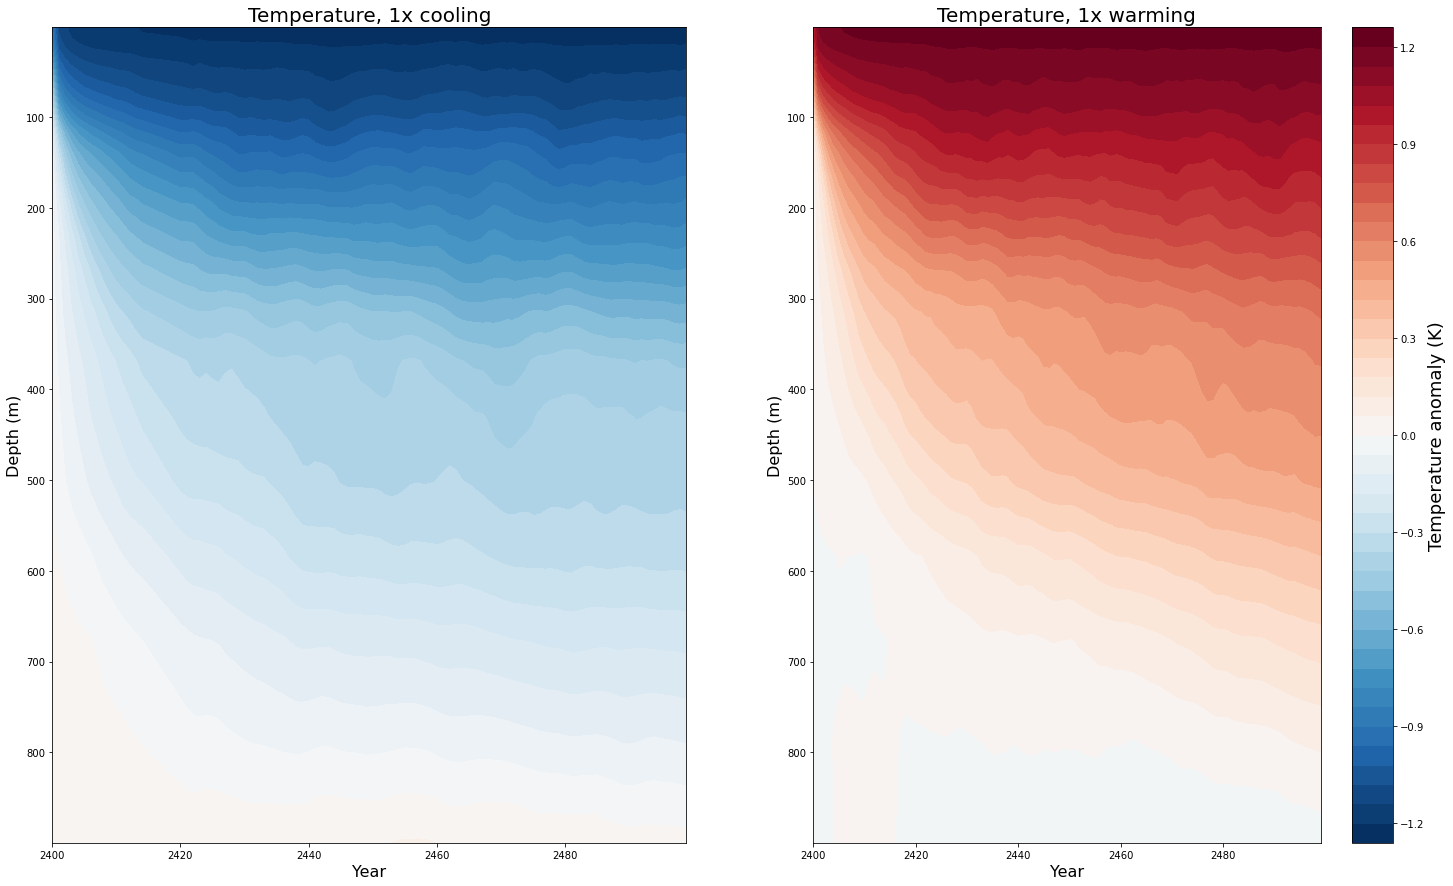

In [24]:
depth = 1000

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (25, 15))

levels = 50

axs = ax[0]
plot = temp_cool_hov.sel(st_ocean = slice(None, depth)).T.plot.contourf(ax=axs, levels=levels, yincrease=False, add_colorbar=False, cmap = 'RdBu_r')
axs.set_title('Temperature, 1x cooling', fontsize=20)
axs.set_ylabel('Depth (m)', fontsize=16)
axs.set_xlabel('Year', fontsize=16)
# axs.set_xticklabels(xlabels, fontsize=15)

axs = ax[1]
plot = temp_warm_hov.sel(st_ocean = slice(None, depth)).T.plot.contourf(ax=axs, levels=levels, yincrease=False, add_colorbar=False, cmap = 'RdBu_r')
axs.set_title('Temperature, 1x warming', fontsize=20)
axs.set_ylabel('Depth (m)', fontsize=16)
axs.set_xlabel('Year', fontsize=16)
# axs.set_xticklabels(xlabels, fontsize=15)

cb = plt.colorbar(plot, orientation='vertical')
cb.set_label(label='Temperature anomaly (K)', fontsize=18)
#plt.savefig('temp_hovmoller_sinusoidal.jpg')

In [13]:
temp_expt = temp_period2
var = area_t * (temp_expt - temp_cont)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_period2_hov = (temp_hov / area_sum).load()

In [14]:
temp_expt = temp_period5
var = area_t * (temp_expt - temp_cont)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_period5_hov = (temp_hov / area_sum).load()

In [15]:
temp_expt = temp_period10
var = area_t * (temp_expt - temp_cont)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_period10_hov = (temp_hov / area_sum).load()

In [16]:
temp_expt = temp_period20
var = area_t * (temp_expt - temp_cont)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_period20_hov = (temp_hov / area_sum).load()

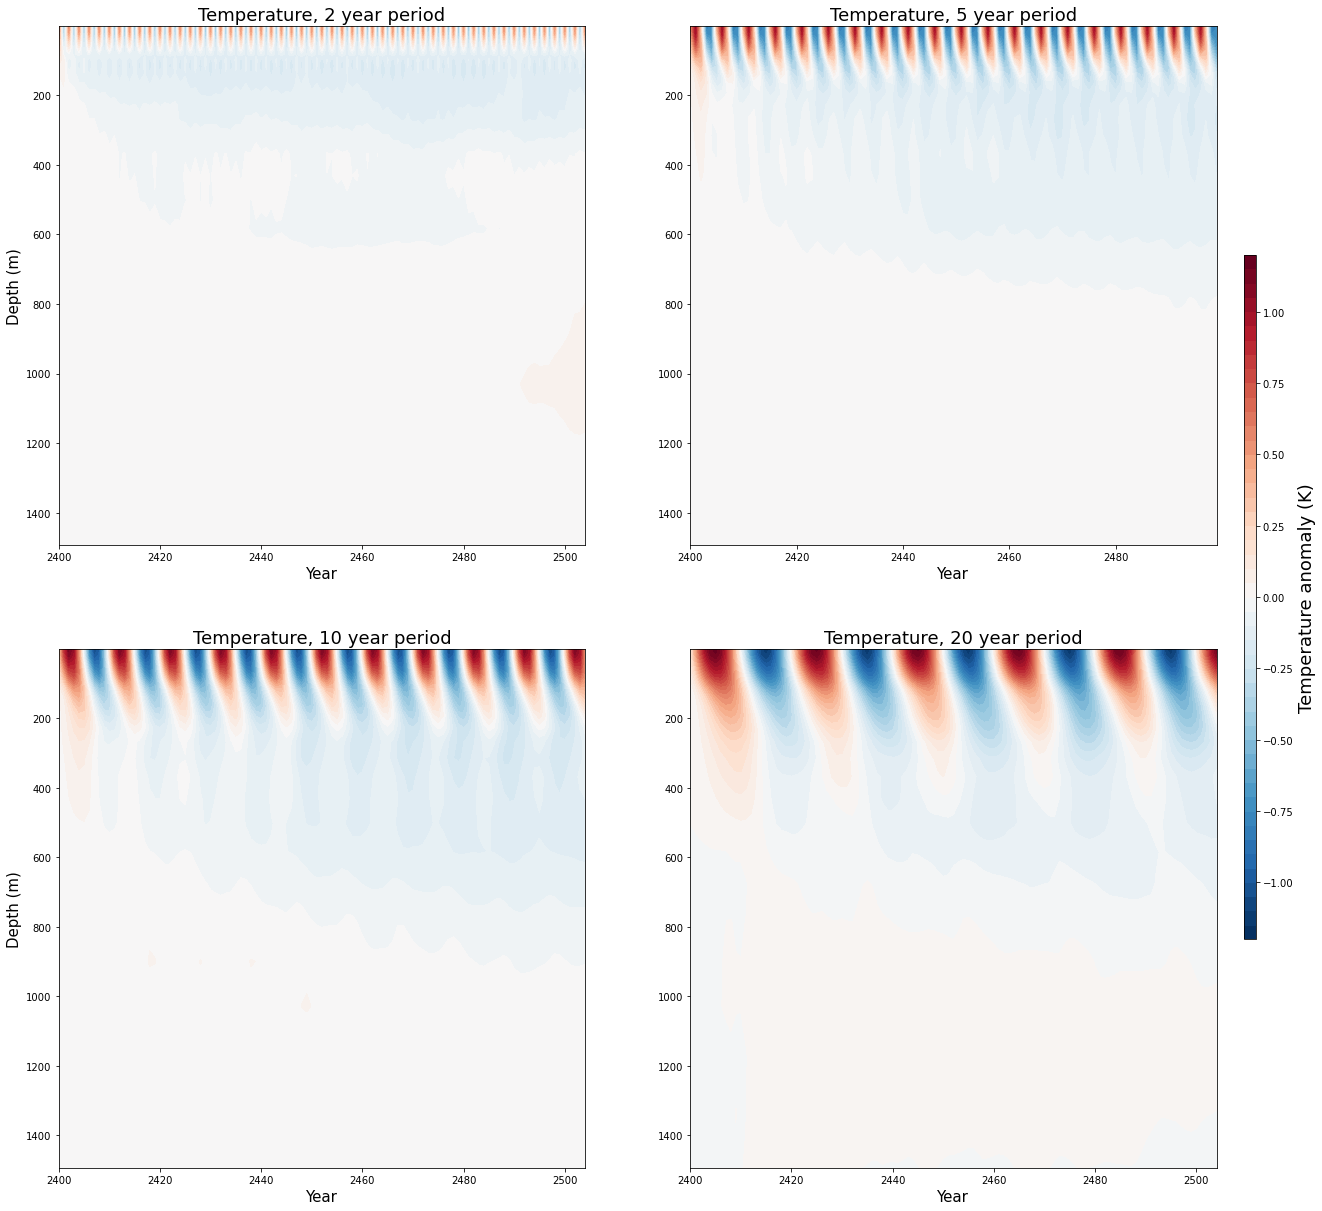

In [17]:
depth = 1500

fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (25, 21))

levels = 50
vmax = np.round(np.max(np.abs(temp_period20_hov.sel(st_ocean = slice(None, depth)).values)), 1)
xlabels = temp_cont.sel(st_ocean = slice(None, depth))['year'].values
ylabels = temp_cont.sel(st_ocean = slice(None, depth))['st_ocean'].values

axs = ax[0, 0]
plot = temp_period2_hov.sel(st_ocean = slice(None, depth)).T.plot.contourf(ax=axs, levels=levels, yincrease=False, add_colorbar=False, vmin = - vmax, vmax = vmax, cmap = 'RdBu_r')
axs.set_title('Temperature, 2 year period', fontsize=18)
axs.set_ylabel('Depth (m)', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
# axs.set_xticklabels(xlabels, fontsize=15)

axs = ax[0, 1]
plot = temp_period5_hov.sel(st_ocean = slice(None, depth)).T.plot.contourf(ax=axs, levels=levels, yincrease=False, add_colorbar=False, vmin = - vmax, vmax = vmax, cmap = 'RdBu_r')
axs.set_title('Temperature, 5 year period', fontsize=18)
axs.set_ylabel('', fontsize=15)
axs.set_xlabel('Year', fontsize=15)

axs = ax[1, 0]
plot = temp_period10_hov.sel(st_ocean = slice(None, depth)).T.plot.contourf(ax=axs, levels=levels, yincrease=False, add_colorbar=False, vmin = - vmax, vmax = vmax, cmap = 'RdBu_r')
axs.set_title('Temperature, 10 year period', fontsize=18)
axs.set_ylabel('Depth (m)', fontsize=15)
axs.set_xlabel('Year', fontsize=15)

axs = ax[1, 1]
plot = temp_period20_hov.sel(st_ocean = slice(None, depth)).T.plot.contourf(ax=axs, levels=levels, yincrease=False, add_colorbar=False, cmap = 'RdBu_r')
axs.set_title('Temperature, 20 year period', fontsize=18)
axs.set_ylabel('', fontsize=15)
axs.set_xlabel('Year', fontsize=15)

cb = plt.colorbar(plot, ax=ax[:,:], orientation='vertical', shrink = 0.6, aspect = 60, pad = 0.02)
cb.set_label(label='Temperature anomaly (K)', fontsize=18)
#plt.savefig('temp_hovmoller_sinusoidal.jpg')